# Single Layer Feedforward Neural Network #

Objectives: create and train a single layer feedforward neural network building on the approach taken in the previous logistic regression notebook. For visualisation purposes (without loss of generality) we will use 2D datasets.

> **Instructions:** Ensure your Python environment is setup with the following additional packages: 
>
> - [sklearn](http://scikit-learn.org/stable/) is simple and efficient tools for data mining and data analysis
> - `t3utils.py` contains unit tests to check your code and some visualiation functions

In [1]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
import t3utils as t3

%matplotlib inline

## A. Preparing your Dataset ##

First, let's generate a dataset to work on. The following code will create a 2-class planar dataset with the same interface used in our previous tutorial. It uses a parametric equation to create a 6 petal spirograph split into two classes. The feature dimension is 2 as opposed to $N\times N\times 3$ in our previous image dataset. Therefore data can be conveniently mapped to coordinates in cartesian plane. Evaluate the following cells to generate both training and test data.

In [2]:
def load_dataset():
    """
    create dataset
    
    Returns:
    (X_train, Y_train), (X_test, Y_test), classes -- training and test data
    """
    
    np.random.seed(2019) # for reproducibility
    n = 256
    X = np.zeros((2*n,2))
    Y = np.zeros((2*n,1), dtype='uint8')
    classes = ['red', 'blue']

    for k in range(2):
        i = range(k*n, (k+1)*n)
        Y[i, 0] = k
        # spirograph data points
        theta = np.linspace(k*np.pi, 2*(k+1)*np.pi, n)
        rho = np.sin(3*(theta+k*np.pi)) + np.random.randn(n) * 0.1
        X[i] = np.c_[rho*np.sin(theta), rho*np.cos(theta)]
    
    
    index = np.random.choice(2*n, size=int(0.05 * 2*n), replace=False)    
    Y_s = Y[index, 0]
    np.random.shuffle(Y_s)
    Y[index, 0] = Y_s
    
    X_train = np.concatenate((X[0:int(n/2),:], X[n:3*int(n/2),:]))
    X_test = np.concatenate((X[int(n/2):n,:], X[3*int(n/2):2*n,:]))
    Y_train = np.concatenate((Y[0:int(n/2),:], Y[n:3*int(n/2),:]))
    Y_test = np.concatenate((Y[int(n/2):n,:], Y[3*int(n/2):2*n,:]))
                             
    return (X_train, Y_train), (X_test, Y_test), classes

> <font color='darkgreen'>**Exercise 1:**</font> Complete the following code to explore dataset dimensions and visualise the training data. 

training set: 256 images
test set: 256 images
features per sample: 2 scalars


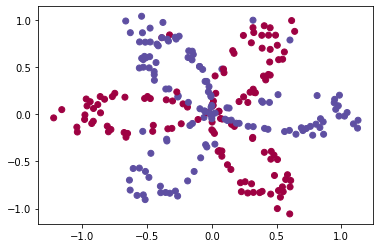

In [3]:
(X_train, Y_train), (X_test, Y_test), classes = load_dataset()

### INPUT YOUR CODE HERE ### (3 lines)
n_train = X_train.shape[0]
n_test = X_test.shape[0]
feature_count = X_train.shape[1]
### END OF YOUR CODE SEGMENT ###  

print("training set: {} images".format(n_train))
print("test set: {} images".format(n_test))
print("features per sample: {} scalars".format(feature_count))
plt.scatter(X_test[:,0], X_test[:,1], c=Y_test.reshape(-1), cmap=plt.cm.Spectral);

> ***Expected Output:***
>
> `training set: 256 images
test set: 256 images
features per sample: 2 scalars`
>
> `X_train` and `X_test` are numpy matrices with two features $(x_1, x_2)$ on each row. `Y_train` and `Y_test` contain our labels, 0 for the `red` class, 1 for the `blue` class, organised as a column vector.
>
> 2D data can be easily displayed as points in a cartesian plane. Our dataset forms 6 petals of a stylised flower, half red (class label $y=0$), half blue (class label $y=1$). The goal is to build a model to classify cartesian coordinates in the 2D plane corresponding to the blue or red petal class.


***

## B. Logistic Regression Model ##

In our previous notebook, we learned how to build and train a logistic regression model to fit our dataset. It performed relatively well on our dataset of images. Let's try and fit our data with the same model. Rather than using our previous implementation, we'll use scikit `sklearn` built-in functions to perform the regression. 

Evaluate the following code which defines a function useful to visualise the decision boundaries for a given model

In [4]:
def plot_model(model, X, Y):
    range0 = np.arange(X[:, 0].min() - 0.1, X[:, 0].max() + 0.1, 0.05)
    range1 = np.arange(X[:, 1].min() - 0.1, X[:, 1].max() + 0.1, 0.05)
    XX, YY = np.meshgrid(range0, range1)
    Y_hat = model(np.c_[XX.ravel(), YY.ravel()])
    Y_hat = Y_hat.reshape(XX.shape)
    plt.contourf(XX, YY, Y_hat, cmap=plt.cm.Spectral)
    plt.ylabel('$x_2$')
    plt.xlabel('$x_1$')
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Spectral)

> <font color='darkgreen'>**Exercise 2:**</font> Complete and evaluate the following cell to report our model accuracy and visualise the model classification output.

model accuracy (training) = 50.8%
testing model (test)= 49.2%


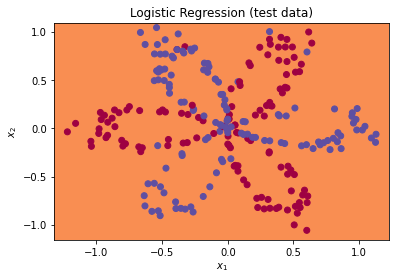

In [5]:
# Define and train Logistic regression model
model = sklearn.linear_model.LogisticRegressionCV(cv=3);
model.fit(X_train, Y_train.ravel());
# Visualise class regions and decision boundaries
plot_model(lambda x: model.predict(x), X_test, Y_test.reshape(-1))
plt.title("Logistic Regression (test data)")

# Report model performance on training and test data
Y_hat_train = model.predict(X_train).reshape(Y_train.shape)
Y_hat_test = model.predict(X_test).reshape(Y_test.shape)
n_train = Y_train.shape[0]
n_test = Y_test.shape[0]

### INPUT YOUR CODE HERE ### (2 lines)
train_acc = sklearn.metrics.accuracy_score(Y_train,Y_hat_train)*100
test_acc = sklearn.metrics.accuracy_score(Y_test,Y_hat_test)*100
### END OF YOUR CODE SEGMENT ###  

print("model accuracy (training) = {:.1f}%".format(train_acc))
print("testing model (test)= {:.1f}%".format(test_acc))

> ***Expected Output:***
> 
> `model accuracy (training) = 50.8%
testing model (test)= 49.2%`

A logistic regression model fails to separate the non-linear dependencies in our dataset. We will now construct a simple single layer neural network to better capture our model complexity.

***

## C. Single Layer Feedforward Neural Network Model ##

We can define a binary single layer feedforward neural network with $n$ hidden units for our two class dataset as follows:
<img src="figs/SLFN.png" style="width:600px">

Here we choose the $\tanh(\cdot)$ activation function for the hidden unit. Given a single input data $x$ (row vector), the model can be summarised with the following set of equations:

$$z^{[1]} = x\, W^{[1]} + b^{[1]}\notag$$ 
$$a^{[1]} = \tanh(z^{[1]})\notag$$
$$z^{[2]} = a^{[1]}\, W^{[2]} + b^{[2]}\notag$$
$$a^{[2]} = \sigma(z^{ [2]})\in (0,1)\notag$$
$$\hat{y} = \mathbb 1\text{{$a^{[2]}$> $1/2$}}$$

where $\theta=(W^{[1]}, b^{[1]}, W^{[2]}, b^{[2]})$ are the model parameters for the hidden and output layers. Just like for the logistic regression, the cross-entropy loss is obtained by: 
$$\ell(y, \hat{y}) =  -y\log(\hat{y}) - (1-y)\log(1-\hat{y})\notag$$

The overall loss for $n_{train}$ training examples is computed from the sum of all individual losses:

$$\mathcal{L} = \frac{1}{n_{train}} \sum_{i=1}^{n_{train}} \ell(y^{(i)}, \hat{y}^{(i)})\notag$$

To implement the single layer feedforward neural network using backprop, we will take the following steps:

- Define the network topology (in our case this is just the number of hidden units $n$)
- Initialise the model weights
- Evaluate loss for the model prediction using foward propagation
- Compute gradients for loss
- Train the model by updating parameters using backprop
- Evaluate performance the model on the test dataset

> <font color='darkgreen'>**Exercise 3:**</font> Setup model topology

In [6]:
def model_config(X, Y, hidden_units=3):
    """
    Arguments:
    X -- n data samples, shape = (n, n_x)
    Y -- ground truth label, column vector of shape (n, 1)
    
    Returns:
    n_x -- number of units in the input layer
    n_y -- number of units in the output layer
    n_h -- number of units in the hidden layer
    """
    
    ### INPUT YOUR CODE HERE ### (3 lines)
    n_x = X.shape[-1]
    n_h = hidden_units
    n_y = Y.shape[-1]
    ### END OF YOUR CODE SEGMENT ###  
    
    assert(X.shape[0] == Y.shape[0])
    return (n_x, n_y, n_h)

In [7]:
X, Y, hidden_units = t3.model_config_test()
(n_x, n_y, n_h) = model_config(X, Y, hidden_units)

print("{} input units".format(n_x))
print("{} output unit".format(n_y))
print("{} hidden units".format(n_h))

2 input units
1 output unit
8 hidden units


> ***Expected Output:***
>
> `2 input units
1 output unit
8 hidden units`

> <font color='darkgreen'>**Exercise 4:**</font> Initialise the model weights to random values drawn from $\mathcal{N}(0,0.01)$ and set bias to zeros. You can use `np.random.randn(n,m) * 0.01` to randomly initialize a matrix of shape $(n,m)$ and `np.zeros((n,m))` to initialize a matrix of shape $(n,m)$ with zeros. 

In [13]:
# Model parameter initialisation
def init_model_parameters(n_x, n_y, n_h):
    """
    n_x -- number of units in the input layer
    n_y -- number of units in the output layer
    n_h -- number of units in the hidden layer
    
    Returns: dictionary containing your parameters:
        W1 -- initialised weight matrix of shape (n_x, n_h)
        b1 -- initialised bias vector of shape (1, n_h)
        W2 -- initialised weight matrix of shape (n_h, n_y)
        b2 -- initialised bias vector of shape (1, n_y)
    """
    
    ### INPUT YOUR CODE HERE ### (4 lines)
    W1 = np.random.randn(n_x,n_h) * 0.01
    b1 = np.zeros((1,n_h))
    W2 = np.random.randn(n_h,n_y) * 0.01
    b2 = np.zeros((1,n_y))
    ### END OF YOUR CODE SEGMENT ###  

    assert(W1.shape == (n_x, n_h))
    assert(b1.shape == (1, n_h))
    assert(W2.shape == (n_h, n_y))
    assert(b2.shape == (1, n_y))
    
    return {"W1": W1, "b1": b1, "W2": W2, "b2": b2}

In [14]:
np.random.seed(2019)
params = init_model_parameters(n_x=2, n_y=1, n_h=3)
np.set_printoptions(precision=5, suppress=True)
print("W1 = {}".format(params["W1"]))
print("b1 = {}".format(params["b1"]))
print("W2.T = {}".format(params["W2"].T))
print("b2 = {}".format(params["b2"]))

W1 = [[-0.00218  0.00821  0.01481]
 [ 0.01332 -0.00362  0.00686]]
b1 = [[0. 0. 0.]]
W2.T = [[ 0.00574  0.00288 -0.00236]]
b2 = [[0.]]


> ***Expected Output:***
>
> `W1 = [[-0.00218  0.00821  0.01481]
 [ 0.01332 -0.00362  0.00686]]
b1 = [[0. 0. 0.]]
W2.T = [[ 0.00574  0.00288 -0.00236]]
b2 = [[0.]]`


> <font color='darkgreen'>**Exercise 5:**</font> Compute the forward propagation $a^{[2]}$ along with a cache dictionary for the values of $z^{[1]}, a^{[1]}, z^{[2]}$. Also return the loss as defined in the equations above if the ground truth parameter is available. Cached values are required to compute partial derivatives for the backprop algorithm. Use `np.tanh()` and `t3.sigmoid()` to compute the activations of the hidden and output layers.

In [40]:
# Forward propagation (inference)
def forward_prop(params, X, Y=None):
    """
    Compute the layer activations and loss if needed

    Arguments:
    params -- dictionary containing model parameters
        W1 -- initialised weight matrix of shape (n_x, n_h)
        b1 -- initialised bias vector of shape (1, n_h)
        W2 -- initialised weight matrix of shape (n_h, n_y)
        b2 -- initialised bias vector of shape (1, n_y)
    X -- n data samples, shape = (n, n_x)
    Y -- optional argument, ground truth label, column vector of shape (n, 1)

    Returns:
    loss -- cross-entropy loss or NaN if Y=None
    cache -- a dictionary containing "Z1", "A1", "Z2", A2"
        Z1 -- matrix of shape (n, n_h)
        A1 -- matrix of shape (n, n_h)
        Z2 -- matrix of shape (n, n_y)
        A2 -- matrix of shape (n, n_y)
    """
    
    
    n = X.shape[0]
    
    # Retrieve model parameters
    ### INPUT YOUR CODE HERE ### (4 lines)
    W1 = params["W1"]
    b1 = params["b1"]
    W2 = params["W2"]
    b2 = params["b2"]
    ### END OF YOUR CODE SEGMENT ###  
    
    # Forward prop: compute cache from X
    ### INPUT YOUR CODE HERE ### (4 lines)
    Z1 = (X @ W1) + b1
    A1 = np.tanh(Z1)
    Z2 = (A1 @ W2) + b2
    A2 = t3.sigmoid(Z2)
    ### END OF YOUR CODE SEGMENT ###  
    
    n_x = params["W1"].shape[0]
    n_y = params["W2"].shape[1]
    n_h = params["W1"].shape[1]
    assert(A1.shape == (n, n_h))
    assert(Z1.shape == (n, n_h))
    assert(A2.shape == (n, n_y))
    assert(Z2.shape == (n, n_y))
    
    loss = float('nan')
    if Y is not None:
        Y_hat = A2
        # Compute the cross-entropy loss
        ### INPUT YOUR CODE HERE ### (1 line)
        loss =  (-Y.T @np.log(Y_hat) - (1-Y.T)@np.log(1-Y_hat))/n
        ### END OF YOUR CODE SEGMENT ###  

        loss = np.squeeze(loss)
        assert(loss.dtype == float)
        
    return {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}, loss

In [41]:
params, X, Y = t3.forward_prop_test()
cache, loss = forward_prop(params, X, Y)

print("np.mean(Z1) = {:.5f}".format(np.mean(cache["Z1"])))
print("np.mean(A1) = {:.5f}".format(np.mean(cache["A1"])))
print("np.mean(Z2) = {:.5f}".format(np.mean(cache["Z2"])))
print("np.mean(A2) = {:.5f}".format(np.mean(cache["A2"])))
print("loss = {:.5f}".format(loss))

np.mean(Z1) = -0.04107
np.mean(A1) = 0.03057
np.mean(Z2) = -1.80453
np.mean(A2) = 0.15003
loss = 1.26159


> ***Expected Output:***
>
> `np.mean(Z1) = -0.04107
np.mean(A1) = 0.03057
np.mean(Z2) = -1.80453
np.mean(A2) = 0.15003
loss = 1.26159`

***

To train the model, we perform a gradient descent by updating our parameters, $\theta \equiv (W^{[1]}, b^{[1]}, W^{[2]}, b^{[2]})$, iteratively using backprop. This optimisation step requires to compute the loss over the training set for the current model parameters $\theta$ and then update their values according to the following rule:  $ \theta = \theta - \lambda\, d\theta$ where $\lambda$ is an hyper-parameters scalar called the learning rate and $d\theta=\frac{\partial\mathcal{L}}{\partial\theta}$. This is repeated a number of iterations as described by another hyper-parameters referred to as the epoch count or epochs (1 epoch = complete presentation of training data).

Using the cache computed during forward propagation, you can now implement the backward propagation step.

> <font color='darkgreen'>**Exercise 6:**</font> Implement the function `back_prop()`<br>
>
> For a single input $x$, a summary of the partial derivatives required to implement backprop for our single layer feedfoward neural network are given below:
>
> $$dz^{[2]}\equiv\frac{\partial \ell}{\partial z^{[2]}} = \frac{\partial \ell}{\partial a^{[2]}}\frac{\partial a^{[2]}}{\partial z^{[2]}} = \frac{\partial \ell}{\partial a^{[2]}}\sigma'(z^{[2]})= \left(\frac{-y}{a^{[2]}}+\frac{1-y}{1-a^{[2]}}\right)\left(a^{[2]}(1-a^{[2]})\right)= a^{[2]}-y \notag$$
>
> $$dW^{[2]}\equiv\frac{\partial \ell}{\partial W^{[2]}} = a^{[1]T} dz^{[2]} $$
> $$db^{[2]}\equiv\frac{\partial \ell}{\partial b^{[2]}} = dz^{[2]}$$
> 
> $$dz^{[1]}\equiv\frac{\partial \ell}{\partial z^{[1]}} = \frac{\partial \ell}{\partial z^{[2]}}\frac{\partial z^{[2]}}{\partial a^{[1]}}\frac{\partial a^{[1]}}{\partial z^{[1]}} = \left(dz^{[2]}\,w^{[2]T}\right)\odot\tanh'(z^{[1]})\notag$$
>
> $$dW^{[1]}\equiv\frac{\partial \ell}{\partial W^{[1]}} = x^T\,dz^{[1]}$$
> $$db^{[1]}\equiv\frac{\partial \ell}{\partial b^{[1]}} = dz^{[1]}$$
>
> Note, $\odot$ denotes the element wise product.
>
> For a $n$ samples stacked in rows in matrix $X$, a vectorised expression for the partial derivatives is given as follows:
> 
> $$dZ^{[2]}= A^{[2]}-Y \tag{1}$$
>
> $$dW^{[2]}=\frac{1}{n} A^{[1]T}\, dZ^{[2]} \tag{2}$$
> $$db^{[2]}_j=\frac{1}{n} \sum_{i=1}^{n} dZ^{[2]}_{i,j} \tag{3}$$
>
> $$dZ^{[1]}=\left(dZ^{[2]}\,W^{[2]T}\right)\odot\tanh'(Z^{[1]})=
% \left(dZ^{[2]}\,W^{[2]T}\right)\odot\left(1-\tanh(Z^{[1]})^2\right)=
\left(dZ^{[2]}\,W^{[2]T}\right)\odot\left(1-{A^{[1]}}^2\right)
\tag{4}$$
>
> $$dW^{[1]}=\frac{1}{n}   X^T \, dZ^{[1]}\tag{5}$$
> $$db^{[1]}_j=\frac{1}{n} \sum_{i=1}^{n}  dZ^{[1]}_{i,j} \tag{6}$$
>
> Use equations (1-6) to implement the `back_prop()` function using the cache containing layers' activations. This step is generally the most challenging task in a DL model implementation as it relies on differential calculus. Checking matrix dimensions generally helps debugging most situations. Note `np.sum(A, axis=0, keepdims=True)` computes the sum along the first dimension of matrix $A$.

In [42]:
# Backward_propagation
def back_prop(params, X, Y, cache):
    """
    Compute back-propagation gradients
    
    Arguments:
    params -- dictionary containing model parameters
        W1 -- initialised weight matrix of shape (n_x, n_h)
        b1 -- initialised bias vector of shape (1, n_h)
        W2 -- initialised weight matrix of shape (n_h, n_y)
        b2 -- initialised bias vector of shape (1, n_y)
    X -- n data samples, shape = (n, n_x)
    Y -- ground truth label, column vector of shape (n, 1)
    cache -- dictionary containing "Z1", "A1", "Z2", A2"
        Z1 -- matrix of shape (n, n_h)
        A1 -- matrix of shape (n, n_h)
        Z2 -- matrix of shape (n, n_y)
        A2 -- matrix of shape (n, n_y)
    
    Returns:
    grads -- dictionary containing your gradients with respect to all parameters
        dW1 -- weight gradient matrix of shape (n_x, n_h)
        db1 -- bias gradient vector of shape (1, n_h)
        dW2 -- weight gradient matrix of shape (n_h, n_y)
        db2 -- bias gradient vector of shape (1, n_y)
    """
    
    n = X.shape[0]
    
    # Retrieve w1 and w2 weights from params dictionary
    ### INPUT YOUR CODE HERE ### (2 lines)
    W1 = params["W1"]
    W2 = params["W2"]
    ### END OF YOUR CODE SEGMENT ###  
        
    # Retrieve A1 and A2 from cache dictionary
    ### INPUT YOUR CODE HERE ### (2 lines)
    A1 = cache["A1"]
    A2 = cache["A2"]
    ### END OF YOUR CODE SEGMENT ###  
    
    # Backprop calculation for dw1, db1, dw2, db2
    ### INPUT YOUR CODE HERE ### (6 lines)
    dZ2 = A2 - Y
    dW2 = A1.T@dZ2
    db2 = (np.sum(dZ2,axis=0,keepdims=True))/n
    dZ1 = A1 - Y
    dW1 = A2.T @ dZ1
    db1 = (np.sum(dZ1,axis=0,keepdims=True))/n
    ### END OF YOUR CODE SEGMENT ###  
        
    return {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

In [43]:
params, X, Y, cache = t3.back_prop_test()
grads = back_prop(params, X, Y, cache)

print("dW1 = {}".format(grads["dW1"]))
print("db1 = {}".format(grads["db1"]))
print("dW2.T = {}".format(grads["dW2"].T))
print("db2 = {}".format(grads["db2"]))


dW1 = [[-1.93994 -1.94181  0.60042  1.1869  -1.11103]]
db1 = [[-1.50452 -1.47461 -0.63059 -0.64186 -0.83104]]
dW2.T = [[1.11441 0.81879 0.25868 1.22153 1.14295]]
db2 = [[-0.49222]]


> ***Expected Output:***
>
> `dW1 = [[ 0.08191  0.03541  0.0049   0.00276 -0.1456 ]
 [-0.12162 -0.12366  0.18207 -0.12262 -0.09771]]
db1 = [[-0.17377 -0.15197  0.21951 -0.13308 -0.04902]]
dW2.T = [[0.37147 0.27293 0.08623 0.40718 0.38098]]
db2 = [[-0.49222]]`

***

> <font color='darkgreen'>**Exercise 7:**</font> Implement the update rule in function `update_params()` <br>
>
> The update rule for gradient descent is given $\theta = \theta - \lambda\, d\theta$ where $\lambda$ denotes the learning rate. The choice for the value of hyper-parameters $\lambda$ is important, a small value will lead to slow convergence while a value too large may result in divergence.
>
> In our case our model parameters $\theta$ describe the tuple
$(W^{[1]}, b^{[1]}, W^{[2]}, b^{[2]})$.

In [29]:
# Update model parameters
def update_params(params, grads, learning_rate=0.8):
    """
    Updates parameters using the gradient descent
    
    Arguments:
    params -- dictionary containing model parameters
        W1 -- weight matrix of shape (n_x, n_h)
        b1 -- bias vector of shape (1, n_h)
        W2 -- weight matrix of shape (n_h, n_y)
        b2 -- bias vector of shape (1, n_y)
    grads -- dictionary containing gradients
        dW1 -- weight gradient matrix of shape (n_x, n_h)
        db1 -- bias gradient vector of shape (1, n_h)
        dW2 -- weight gradient matrix of shape (n_h, n_y)
        db2 -- bias gradient vector of shape (1, n_y)
    learning_rate -- learning rate of the gradient descent (hyper-parameters)

    Returns:
    params -- dictionary containing updated parameters
        W1 -- updated weight matrix of shape (n_x, n_h)
        b1 -- updated bias vector of shape (1, n_h)
        W2 -- updated weight matrix of shape (n_h, n_y)
        b2 -- updated bias vector of shape (1, n_y)
    """

    # Retrieve each parameter from the dictionary "parameters"
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = params["W1"]
    b1 = params["b1"]
    W2 = params["W2"]
    b2 = params["b2"]
    ### END CODE HERE ###
    
    # Retrieve each gradient from the dictionary "grads"
    ### START CODE HERE ### (≈ 4 lines of code)
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    ## END CODE HERE ###
    
    # Update rule for each parameter
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = W1 - (learning_rate * dW1)
    b1 = b1 - (learning_rate * b1)
    W2 = W2 - (learning_rate * W2)
    b2 = b2 - (learning_rate * b2)
    ### END CODE HERE ###
        
    return {"W1": W1, "b1": b1, "W2": W2, "b2": b2}

In [30]:
params, grads = t3.update_params_test()
params = update_params(params, grads)

print("W1 = {}".format(params["W1"]))
print("b1 = {}".format(params["b1"]))
print("W2.T = {}".format(params["W2"].T))
print("b2 = {}".format(params["b2"]))

W1 = [[-0.26965  3.38549  0.6373   0.68604 -0.74118]
 [ 0.35687  0.18441  0.71615  0.43549  1.60339]]
b1 = [[-0.33793 -0.06899  0.00338 -0.103    0.0489 ]]
W2.T = [[-0.03786  0.53443  0.09296  0.16919 -0.10071]]
b2 = [[-0.19267]]


> ***Expected Output:***
>
> `W1 = [[-0.26965  3.38549  0.6373   0.68604 -0.74118]
 [ 0.35687  0.18441  0.71615  0.43549  1.60339]]
b1 = [[-1.32899 -1.20158 -0.15703  0.4257   0.9854 ]]
W2.T = [[ 0.60585  2.20273 -0.38625  0.65574  0.1165 ]]
b2 = [[-0.18005]]`

*** 

> <font color='darkgreen'>**Exercise 8:**</font> Complete the function below to train your single layer feedforward neural network model by repeatedly performing inference, computing parameter gradients using backprop, and updating parameters.

In [44]:
# Parameter optimisation using backprop
def model_fit(params, X, Y, epochs=2000, learning_rate=0.8, verbose=False):
    """
    Optimise model parameters performing gradient descent
    
    Arguments:
    params -- dictionary containing model parameters
        W1 -- initialised weight matrix of shape (n_x, n_h)
        b1 -- initialised bias vector of shape (1, n_h)
        W2 -- initialised weight matrix of shape (n_h, n_y)
        b2 -- initialised bias vector of shape (1, n_y)
    X -- n data samples  (n, n_x)
    Y -- ground truth label vector of size (n, n_y)
    epochs -- number of iteration updates through dataset
    learning_rate -- learning rate of the gradient descent
    
    Returns:
    params -- dictionary with optimised parameters
    grads -- dictionary with final gradients
    loss_log -- list of loss values for every 1000 updates
    """
    
    loss_log = []
    for i in range(epochs):
        ### INPUT YOUR CODE HERE ### (5 lines)
        cache, loss = forward_prop(params, X, Y)
        grads = back_prop(params, X, Y, cache)
        params = update_params(params, grads, learning_rate)
        ### END OF YOUR CODE SEGMENT ###  
        
        # logs
        if i % 1000 == 0:
            loss_log.append(loss.item())
            if verbose:
                print("Loss after {} iterations: {:.3f}".format(i, loss))
     
    return params, grads, loss_log

In [45]:
params, X, Y = t3.forward_prop_test()
params, grads, loss_log = model_fit(params, X, Y, epochs = 2100, verbose=True)

print("W1 = {}".format(params["W1"]))
print("b1 = {}".format(params["b1"]))
print("W2.T = {}".format(params["W2"].T))
print("b2 = {}".format(params["b2"]))

Loss after 0 iterations: 1.262
Loss after 1000 iterations: 0.693
Loss after 2000 iterations: 0.693
W1 = [[ 2.42889 -0.48412 -1.37602  0.51602 -0.38528]
 [ 1.71991  1.01619  1.6411   0.96391  0.97563]]
b1 = [[0. 0. 0. 0. 0.]]
W2.T = [[0. 0. 0. 0. 0.]]
b2 = [[0.]]


> ***Expected Output:***
>
> `Loss after 0 iterations: 1.262
Loss after 1000 iterations: 0.002
Loss after 2000 iterations: 0.001
W1 = [[ 5.82809 -4.5018   0.15839  0.02176 -0.62088]
 [ 3.95058 -1.81251  2.21641  0.47214  0.75909]]
b1 = [[-1.26981  0.0359  -0.83395 -3.19964  1.01775]]
W2.T = [[ 7.87515 -4.7095   1.23063  0.18959 -0.29637]]
b2 = [[-0.52574]]`

***

Once the model parameters are optimised, we can use our single layer feedforward neural network  model to predict the petal class for our dataset `X_test`. 

> <font color='darkgreen'>**Exercise 9:**</font> Implement the `model_predict()` function<br>
>
> Perform model inference on input $X$ and convert activation output to predictions (0/1 values): 
> 
> $\hat{y}=\mathbb 1\text{{$a^{[2]}$> $1/2$}} = \begin{cases}
      1 & \text{if $a^{[2]}$}> 1/2 \\
      0 & \text{otherwise}
    \end{cases}$  
>    
> Avoid python iteration and `if` statements preferring numpy vectorial code.

In [46]:
# Model inference
def model_predict(params, X):
    '''
    Predict class label using model parameters
    
    Arguments:
    params -- dictionary containing model parameters
        W1 -- optimised weight matrix of shape (n_x, n_h)
        b1 -- optimised bias vector of shape (1, n_h)
        W2 -- optimised weight matrix of shape (n_h, n_y)
        b2 -- optimised bias vector of shape (1, n_y)
    X -- n data samples  (n, n_x)
    
    Returns:
    Y_hat -- vector with class predictions for examples in X
    '''
    
    ### INPUT YOUR CODE HERE ### (2 lines)
    cache, _ = forward_prop(params, X)
    Y_hat = (cache["A2"] > 0.5) * 1 # Convert activations to {0,1} predictions
    ### END OF YOUR CODE SEGMENT ###  
    
    n = X.shape[0]
    assert(Y_hat.shape == (n, 1))    
    return Y_hat

In [47]:
params, X = t3.model_predict_test()
Y_hat = model_predict(params, X)

print("predictions.T = {}".format(Y_hat.T))

predictions.T = [[1 1 0]]


> ***Expected Output:***
>
> `predictions.T = [[1 1 0]]`

***

## D. Stitching it all together ##

We can now fit all the previous step into a model function that will take our training and testing datasets as input along with our two hyper-parameters (learning rate and number of epochs for training) and that will return trained model parameters along training and testing logs useful to study the training behaviour of our backprop optimisation. 

> <font color='darkgreen'>**Exercise 10:**</font> Implement the following function and evaluate your model on our dataset

In [58]:
# SLFN model
def slfn_model(X_train, Y_train, X_test, Y_test, hidden_units=3, epochs=10000, learning_rate=0.5):
    '''
    Build, train and evaluate the logistic regression model
    
    Arguments:
    X_train -- training set a numpy array of shape (n_train, n_x)
    Y_train -- training ground truth vector (0=dog, 1=cat) of size (n_train, n_y)
    X_test -- testing set a numpy array of shape (n_test, n_x)
    Y_test -- testing ground truth vector (0=dog, 1=cat) of size (n_test, n_y)
    hidden_units -- number of units in hidden layer
    epochs -- number of iteration updates through dataset for training (hyper-parameters)
    learning_rate -- learning rate of the gradient descent (hyper-parameters)
    
    Returns:
    model -- dictionary 
        PARAMS -- parameters
        LOSS -- log of training loss
        GRADS -- final 
        ACC -- array with training and testing accuracies
        LR -- learning rate
    '''
    
    ### INPUT YOUR CODE HERE ### (7 lines)
    (n_x, n_y, n_h) = model_config(X_train, Y_train, hidden_units)
    params = init_model_parameters(n_x, n_y, n_h)
    params, grads, loss = model_fit(params, X_train, Y_train, epochs, learning_rate, verbose=False)
    Y_hat_train = model_predict(params, X_train)
    Y_hat_test = model_predict(params, X_test)
    train_acc = sklearn.metrics.accuracy_score(Y_train,Y_hat_train)
    test_acc = sklearn.metrics.accuracy_score(Y_test, Y_hat_test)
    ### END OF YOUR CODE SEGMENT ###  

    print("{:.1f}% training acc.".format(train_acc))
    print("{:.1f}% test acc.".format(test_acc))
        
    return {"PARAMS": params, "LOSS": loss, "GRADS": grads, "ACC": [train_acc, test_acc], "LR": learning_rate}

0.5% training acc.
0.5% test acc.


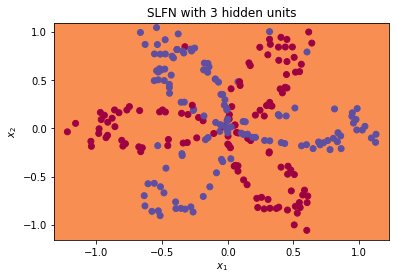

In [59]:
model = slfn_model(X_train, Y_train, X_test, Y_test)
params = model["PARAMS"]

# Plot the decision boundary
plot_model(lambda x: model_predict(params, x), X_test, Y_test.reshape(-1))
_ = plt.title("SLFN with {} hidden units".format(params["W1"].shape[1]))

> ***Expected Output:***
>
> `94.5% training acc.
91.0% test acc.`

***

Accuracy is much improved compared to the logistic regression model. With 3 hidden units, our model seems to have captured the essence of the two-class petals. Single layer feedforward neural network are able to learn highly non-linear detection regions which is not possible with simple logistic regression models.

Evaluate the following code to experiment with the topology hyper-parameter that determines the number of hidden units, sometimes referred to as the network capacity. It may take a few minutes to complete.

SLFN with 1 hidden units
0.5% training acc.
0.5% test acc.
SLFN with 2 hidden units
0.5% training acc.
0.5% test acc.
SLFN with 3 hidden units
0.5% training acc.
0.5% test acc.
SLFN with 4 hidden units
0.5% training acc.
0.5% test acc.
SLFN with 8 hidden units
0.5% training acc.
0.5% test acc.
SLFN with 16 hidden units
0.5% training acc.
0.5% test acc.


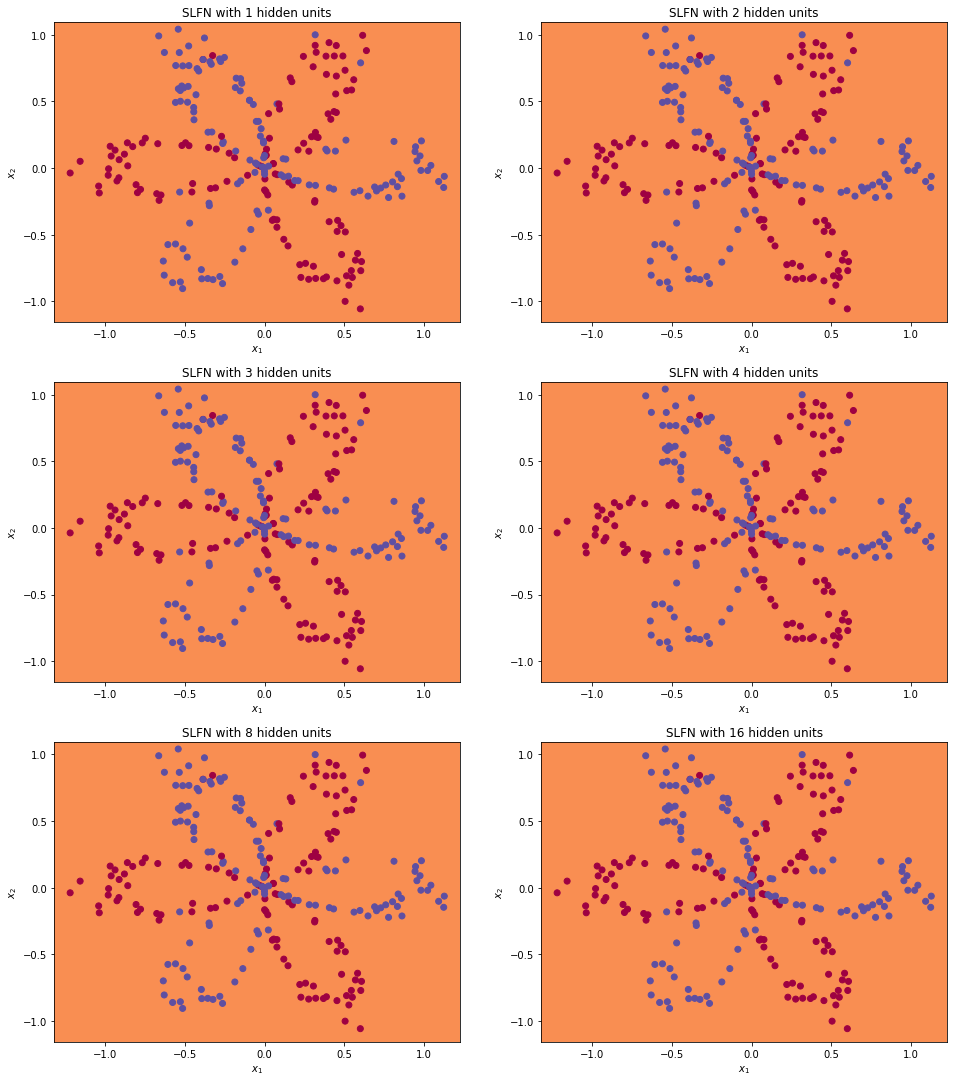

In [60]:
plt.figure(figsize=(16, 32))
for i, hidden_units in enumerate([1, 2, 3, 4, 8, 16]):
    print("SLFN with {} hidden units".format(hidden_units))
    model = slfn_model(X_train, Y_train, X_test, Y_test, hidden_units)
    params = model["PARAMS"]
    plt.subplot(5, 2, i+1)
    plot_model(lambda x: model_predict(params, x), X_test, Y_test.reshape(-1))
    _ = plt.title("SLFN with {} hidden units".format(hidden_units))

- Larger models with more hidden units are able to fit the training better but eventually the largest models overfit the data (training accuracy still going up while testing accuracy starts decreasing)
- It is possible to use larger models and prevent overfitting with a technique called regularisation.
- For our datasets, the best hidden layer size appears to be around 3 hidden units with little noticeable overfitting.

***

Scikit provides a few 2D datasets that you may want to experiment with.

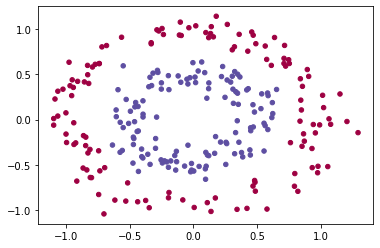

In [61]:
datasets = [sklearn.datasets.make_circles(n_samples=512, factor=.5, noise=.1), 
            sklearn.datasets.make_moons(n_samples=512, noise=.3),
            sklearn.datasets.make_gaussian_quantiles(mean=None, cov=0.3, n_samples=512, n_features=2, n_classes=2, shuffle=True, random_state=None)]
index = int(np.random.randint(len(datasets), size=1))
X, Y = datasets[index]
Y = Y.reshape(Y.shape[0], 1)
X_train= X[0:256, :]
X_test= X[256:512, :]
Y_train= Y[0:256, :]
Y_test= Y[256:512, :]
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train.reshape(-1), s=20, cmap=plt.cm.Spectral);

0.5% training acc.
0.5% test acc.


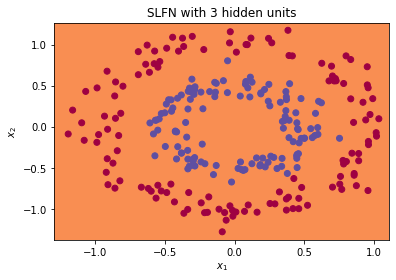

In [62]:
model = slfn_model(X_train, Y_train, X_test, Y_test)
params = model["PARAMS"]

# Plot the decision boundary
plot_model(lambda x: model_predict(params, x), X_test, Y_test.reshape(-1))
_ = plt.title("SLFN with {} hidden units".format(params["W1"].shape[1]))

-- EOF --